In [1]:
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14451386960461900101
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1406218649
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17617769368028899354
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
plt.rcParams["figure.figsize"] = (15,15)

In [4]:
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [5]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [6]:
image_size = 512
train_path = 'data'
epochs = 5
batch_size = 3

## Training Ids
train_ids = next(os.walk(train_path))[1]
random.shuffle(train_ids)

## Validation Data Size
val_data_size = 6

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [7]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(3, 512, 512, 3) (3, 512, 512, 1)


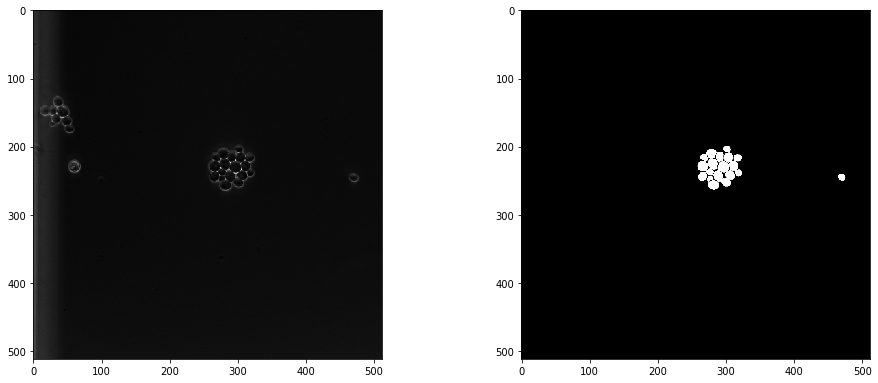

In [8]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [9]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [10]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [11]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/5
27/27 [==============================] - 15s 537ms/step - loss: 0.2431 - acc: 0.9781 - val_loss: 0.1005 - val_acc: 0.9721
Epoch 2/5
27/27 [==============================] - 5s 177ms/step - loss: 0.0472 - acc: 0.9832 - val_loss: 0.0276 - val_acc: 0.9721
Epoch 3/5
27/27 [==============================] - 5s 179ms/step - loss: 0.0157 - acc: 0.9864 - val_loss: 0.0255 - val_acc: 0.9721
Epoch 4/5
27/27 [==============================] - 5s 177ms/step - loss: 0.0145 - acc: 0.9862 - val_loss: 0.0245 - val_acc: 0.9721
Epoch 5/5
27/27 [==============================] - 5s 182ms/step - loss: 0.0108 - acc: 0.9929 - val_loss: 0.0211 - val_acc: 0.9906


In [13]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

#result = result > 0.5

Text(0.5, 1.0, 'prediction (without thresholding)')

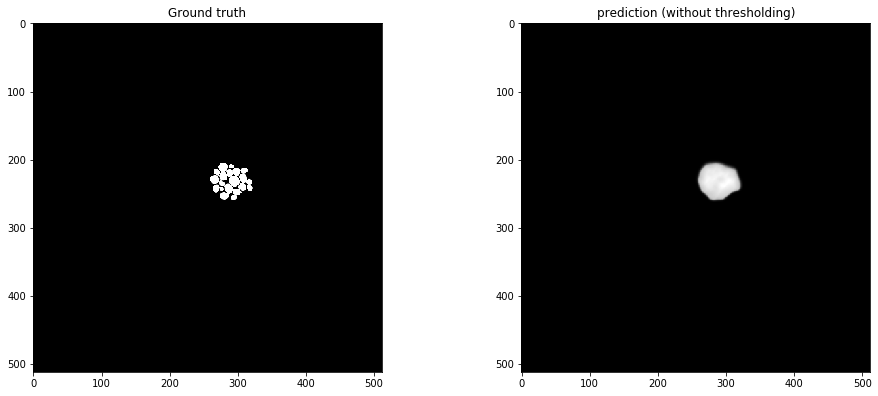

In [16]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")
ax.set_title('Ground truth')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")
ax.set_title('prediction (without thresholding)')

Text(0.5, 1.0, 'prediction (without thresholding) [zoomed]')

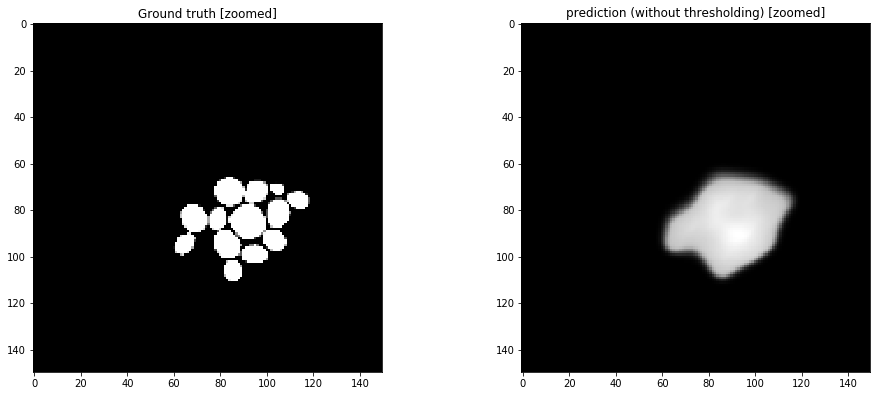

In [17]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size))[150:300,200:350], cmap="gray")
ax.set_title('Ground truth [zoomed]')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size))[150:300,200:350], cmap="gray")
ax.set_title('prediction (without thresholding) [zoomed]')